In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import pandas as pd
import platform
import random
from matplotlib import pyplot as plt

2024-07-10 00:05:42.996485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 00:05:43.072852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 00:05:43.073442: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 00:05:44.051462: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 00:05:45.121568: W tensorflow/compiler/tf

In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [3]:
def train_test_split(df, train_perc, seed):
    
    shuffled_df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    tr_samples = int(len(df)*train_perc)
    
    train_df = shuffled_df.iloc[:tr_samples]
    
    test_df = shuffled_df.iloc[tr_samples:]
    
    return [train_df,test_df]

In [4]:
import ast
def load_data(data_directory, file_name):
    loaded_df = pd.read_csv(data_directory+'/'+file_name)
    loaded_df['keypoints'] = loaded_df['keypoints'].apply(lambda x: np.array(ast.literal_eval(x)).reshape(17,3))
    return loaded_df

In [5]:
def load_data_object(data_directory, file_name):
    loaded_df = pd.read_csv(data_directory+'/'+file_name)
    loaded_df['object'] = loaded_df['object'].apply(lambda x: np.array(ast.literal_eval(x.replace('\n',
                                                                                                     '').replace('  ',
                                                                                                                  ' ').replace(' ',
                                                                                                                               ','))))
    return loaded_df

In [6]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS🐑🏀/Human Action Recognition'
else:
    root_directory = ''
    data_directory = '../human_pose_local/archive/Human Action Recognition'

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is 
data directory is ../human_pose_local/archive/Human Action Recognition


In [7]:
file_name = 'preprocessed_train_set_movenet_lightning.csv'
load_df_lightning = load_data(data_directory, file_name)
load_df_lightning

,filename,label,category,keypoints
0,Image_1.jpg,sitting,11,"[[0.06167532131075859, 0.508802056312561, 0.30..."
1,Image_2.jpg,using_laptop,14,"[[0.2107752561569214, 0.995250403881073, 0.705..."
2,Image_3.jpg,hugging,7,"[[0.09106554090976715, 0.47515493631362915, 0...."
3,Image_4.jpg,sleeping,12,"[[0.270770400762558, 0.4170025885105133, 0.304..."
4,Image_5.jpg,using_laptop,14,"[[0.02712862566113472, 0.23545874655246735, 0...."
...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[[0.023519866168498993, 0.40524551272392273, 0..."
12596,Image_12597.jpg,clapping,1,"[[0.035674747079610825, 0.25097161531448364, 0..."
12597,Image_12598.jpg,sitting,11,"[[0.045870888978242874, 0.51141756772995, 0.52..."
12598,Image_12599.jpg,dancing,3,"[[0.2243669480085373, 0.4571295976638794, 0.59..."


In [8]:
obj_rec_df = load_data_object(data_directory, 'objects_train_set_.csv')
obj_rec_df

,filename,label,category,object
0,Image_1.jpg,sitting,11,"[[2.30433943e-05, 2.09117115e-05, 0.0001094206..."
1,Image_2.jpg,using_laptop,14,"[[0.000194256383, 5.70762568e-05, 7.59727118e-..."
2,Image_3.jpg,hugging,7,"[[0.0023470642, 9.80546029e-05, 8.46892508e-05..."
3,Image_4.jpg,sleeping,12,"[[1.49514672e-05, 3.8803053e-05, 9.94285947e-0..."
4,Image_5.jpg,using_laptop,14,"[[4.64461882e-05, 1.18643238e-05, 1.27570092e-..."
...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[[0.000371369533, 7.97717803e-05, 9.82385682e-..."
12596,Image_12597.jpg,clapping,1,"[[4.56992666e-06, 1.96655365e-05, 2.72679481e-..."
12597,Image_12598.jpg,sitting,11,"[[2.74121885e-05, 5.06073266e-05, 3.48939357e-..."
12598,Image_12599.jpg,dancing,3,"[[0.000135590744, 0.000205077304, 0.0005233173..."


In [9]:
# merge the two dataframes on filename label and category
merged_df = pd.merge(load_df_lightning, obj_rec_df, on=['filename', 'label', 'category'])

In [10]:
# apply the sorting to the column 'object' of the dataframe
merged_df['object'] = merged_df['object'].apply(lambda x: np.argsort(x[0][::-1]/1000)[:5])

In [11]:
merged_df['keypoints'] = merged_df['keypoints'].apply(lambda x: x[:, :2].reshape(17*2))

In [12]:
merged_df

,filename,label,category,keypoints,object
0,Image_1.jpg,sitting,11,"[0.06167532131075859, 0.508802056312561, 0.000...","[439, 2, 350, 247, 591]"
1,Image_2.jpg,using_laptop,14,"[0.2107752561569214, 0.995250403881073, 0.1062...","[183, 207, 994, 241, 303]"
2,Image_3.jpg,hugging,7,"[0.09106554090976715, 0.47515493631362915, 0.0...","[548, 190, 183, 228, 16]"
3,Image_4.jpg,sleeping,12,"[0.270770400762558, 0.4170025885105133, 0.2147...","[342, 381, 190, 226, 865]"
4,Image_5.jpg,using_laptop,14,"[0.02712862566113472, 0.23545874655246735, 0.0...","[882, 874, 107, 181, 381]"
...,...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[0.023519866168498993, 0.40524551272392273, -0...","[239, 524, 120, 362, 212]"
12596,Image_12597.jpg,clapping,1,"[0.035674747079610825, 0.25097161531448364, 0....","[381, 212, 30, 838, 745]"
12597,Image_12598.jpg,sitting,11,"[0.045870888978242874, 0.51141756772995, 0.000...","[199, 877, 853, 544, 91]"
12598,Image_12599.jpg,dancing,3,"[0.2243669480085373, 0.4571295976638794, 0.192...","[213, 190, 307, 32, 493]"


In [13]:
train_perc = 0.75
train, val = train_test_split(df = merged_df, train_perc = train_perc, seed = 42)

In [14]:
train

,filename,label,category,keypoints,object
0,Image_11386.jpg,cycling,2,"[0.03913639858365059, 0.640947699546814, 0.007...","[164, 288, 841, 243, 31]"
1,Image_6867.jpg,running,10,"[0.034662388265132904, -0.053831007331609726, ...","[589, 243, 575, 545, 366]"
2,Image_1324.jpg,fighting,6,"[0.05043254420161247, 0.8546696901321411, 0.01...","[375, 307, 283, 510, 495]"
3,Image_2253.jpg,drinking,4,"[0.024878162890672684, 0.5767847895622253, 0.0...","[269, 458, 517, 164, 151]"
4,Image_11278.jpg,sleeping,12,"[0.2615218162536621, 0.879084050655365, 0.2294...","[75, 226, 183, 78, 508]"
...,...,...,...,...,...
9445,Image_10607.jpg,cycling,2,"[0.0720132365822792, 0.4243779480457306, 0.006...","[226, 494, 38, 465, 313]"
9446,Image_11742.jpg,calling,0,"[0.05903799831867218, 0.5274866223335266, 0.00...","[589, 278, 380, 84, 535]"
9447,Image_7719.jpg,cycling,2,"[0.03722040355205536, 0.525275707244873, 0.004...","[90, 370, 154, 288, 393]"
9448,Image_9690.jpg,using_laptop,14,"[0.073097825050354, 0.6763879656791687, 0.0030...","[381, 536, 160, 458, 239]"


In [15]:
def create_dataset(df, batch_size , shuffle=False, use_object=False):
    
    labels = df['category']
    
    kpoints = df['keypoints']

    # merge the two arrays
    if use_object:
        df['input'] = df.apply(lambda x: np.concatenate((x['keypoints'], x['object'])), axis=1)
    else:
        df['input'] = df['keypoints']

    if use_object:
        data = np.zeros((len(kpoints), 17*2+5))
    else:    
        data = np.zeros((len(kpoints), 17*2))
    
    for i, row in enumerate(df['input']): 
        data[i,:] = np.array(row)
        
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    
    if shuffle:
        dataset = dataset.shuffle(len(data))
        
    dataset = dataset.repeat()
    
    dataset = dataset.batch(batch_size = batch_size)
    
    return dataset

In [16]:
batch_s = 5
use_object = False

dataset_train = create_dataset(train, batch_s, shuffle=False, use_object=use_object)
train_steps = int(np.ceil(len(train)/batch_s))

dataset_val = create_dataset(val, batch_s, shuffle=False, use_object=use_object)
val_steps = int(np.ceil(len(val)/batch_s))

In [17]:
# Define the model
if use_object:
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(17*2+5,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(15, activation='softmax')
    ])
else:
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(17*2,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(15, activation='softmax')
    ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,815 (18.81 KB)

 Trainable params: 4,815 (18.81 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the model
for _ in range(100):
    dataset_train = create_dataset(train, 5, shuffle=True, use_object=use_object)
    dataset_val = create_dataset(val, 5)
    model.fit(dataset_train, epochs=1, validation_data=dataset_val, steps_per_epoch=train_steps, validation_steps=val_steps)


1890/1890 ━━━━━━━━━━━━━━━━━━━━ 3s 994us/step - accuracy: 0.1758 - loss: 2.4473 - val_accuracy: 0.2495 - val_loss: 2.1847
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2686 - loss: 2.1485 - val_accuracy: 0.3013 - val_loss: 2.0890
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 2s 928us/step - accuracy: 0.3009 - loss: 2.0875 - val_accuracy: 0.3121 - val_loss: 2.0627
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3326 - loss: 2.0411 - val_accuracy: 0.3073 - val_loss: 2.0639
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3342 - loss: 1.9946 - val_accuracy: 0.3206 - val_loss: 2.0198
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3310 - loss: 1.9899 - val_accuracy: 0.3178 - val_loss: 2.0483
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3479 - loss: 1.9702 - val_accuracy: 0.3429 - val_loss: 2.0055
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3599 - loss: 1.9367 - val_accuracy: 0.3362 - val_loss: 2.0090
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step -

In [19]:
# predict on the validation set
y_pred = model.predict(dataset_val, steps=val_steps)

630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step


In [20]:
pred = np.argmax(y_pred, axis=1)

# confusion matrix
from sklearn.metrics import confusion_matrix

y_true = val['category']

conf_matrix = confusion_matrix(y_true, pred)

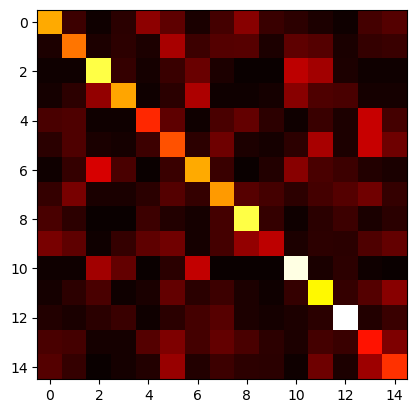

In [21]:
plt.imshow(conf_matrix, cmap='hot')
plt.show()

   1/1890 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step

1890/1890 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step


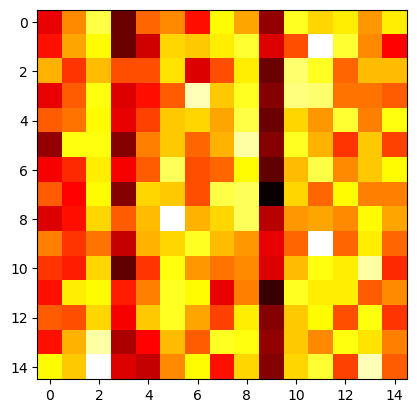

In [22]:
# predict on the training set
y_pred_train = model.predict(dataset_train, steps=train_steps)

pred_train = np.argmax(y_pred_train, axis=1)

# confusion matrix
y_true_train = train['category']

conf_matrix_train = confusion_matrix(y_true_train, pred_train)

plt.imshow(conf_matrix_train, cmap='hot')
plt.show()

In [23]:
import gensim.downloader as W2V

# Load the pre-trained Word2Vec model
model = W2V.load("word2vec-google-news-300")

# Get the vector for a specific word
word = "apple"
vector = model[word]

print(f"Vector for '{word}': {vector}")
